In [1]:
#to run first and foremost
import os
os.chdir('..')

# Approach
This notebook will present how we conducted our experiments, and will evaluate our various models.

## Outline of the approach
We want to apply [DiffInstruct](https://arxiv.org/abs/2305.18455) to finetune a generator (obtained with adversarial training) with a better diffusion model (DM). The main goal of DiffInstruct is to distill the knowledge of a DM (typically very powerful but long to sample from) into a weaker model from which sampling is fast. DiffInstruct (DI), as presented in the original paper, can be applied to single-step DMs as well as generators as long as the generated samples are differentiable with respect to the generator's parameters. In the associated [Github](https://github.com/pkulwj1994/diff_instruct/tree/main), the authors focus on single step DMs. We will here focus on a generated trained with an adversarial procedure. The code that implements the DI method (in `DiffInstruct.py`) is heavily inspired from the previous Github repository. 

We will here provide an overview of:
- The training of our teacher DM.
- The training of our student generator.
- The distillation of the teacher's knowledge to the student by DI.
- Evaluate all these models to see how they compare.

## Pre-trainings
Here we detail the obtention of the DM and the generator. We will use FashionMNIST for dataset. This will allow efficiency both in the training and in sampling. Using a more complex dataset is besides our point, we want to replicate and showcase DI.

### Diffusion model
We pre trained our teacher model. It has the architecture of a simple UNet and relies on a sinusoidal embedding for the timesteps.

Training can be reproduced with the following command (from the root of this repo):
```
python3 trainDM.py
```
Some parameters can be changed. To replicate a model with the same architecture as the one we ended up with, please run :

```
python3 trainDM.py --num_layers 4 --hidden_channels 128 --timesteps 2000 --epohs 150
```
In our case, early stopping was triggered after 110 epochs. The early stopping was done according to a validation procedure relying on 20% of the dataset. 
The DM will be saved in `DM_models`. We provide a visualization of the training logs in the next cell.

Bear in mind that this training took a long time (>1 hour with a batch size of 128 on a GPU). For your information, 4GB of vRAM should be enough, and if not reducing the batch size to 64 will definetly be.

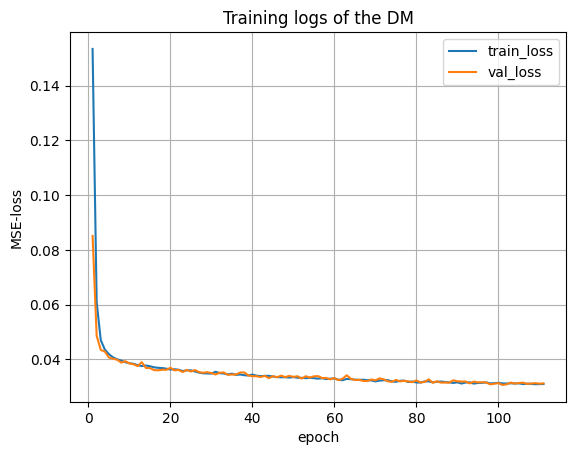

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DM_logs = pd.read_csv('DM_models/UNet_4layers_128hc_2000steps_logs.csv')
DM_logs.plot('epoch')
plt.grid(True)
plt.ylabel("MSE-loss")
plt.title("Training logs of the DM")
plt.show()

Now let's load and sample from this model.

In [31]:
from DM import UNetDM
from train_DM import cosine_beta_schedule
import torch

def load_DM(model_path, input_channels, hidden_channels, num_layers, timesteps, device):
    model = UNetDM(input_channels, hidden_channels, num_layers, timesteps).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def sample_DM(model, num_samples, timesteps, device):
    betas = torch.tensor(cosine_beta_schedule(timesteps)).to(device)
    samples = model.sample_images(num_samples=num_samples, betas=betas, device=device)
    return samples

def visualize_images(images, nrow=5):
    from torchvision.utils import make_grid
    grid = make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

DM_path = "DM_models/UNet_4layers_128hc_2000steps.pth"  # Path to the trained model
input_channels = 1
hidden_channels = 128
num_layers = 4
timesteps = 2000
#100 samples will take around 4 minutes but we will need them to have a somewhat decent sample for later quantitative evaluation
num_samples = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
DM = load_DM(DM_path, input_channels, hidden_channels, num_layers, timesteps, device)
DM_samples = sample_DM(DM, num_samples, timesteps, device)
DM_samples = torch.stack(DM_samples)
DM_samples = DM_samples.reshape(-1, 1, 28, 28)

/tmp/ipykernel_514598/3214659123.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [30]:
DM_samples.shape[:25]

torch.Size([100, 1, 28, 28])

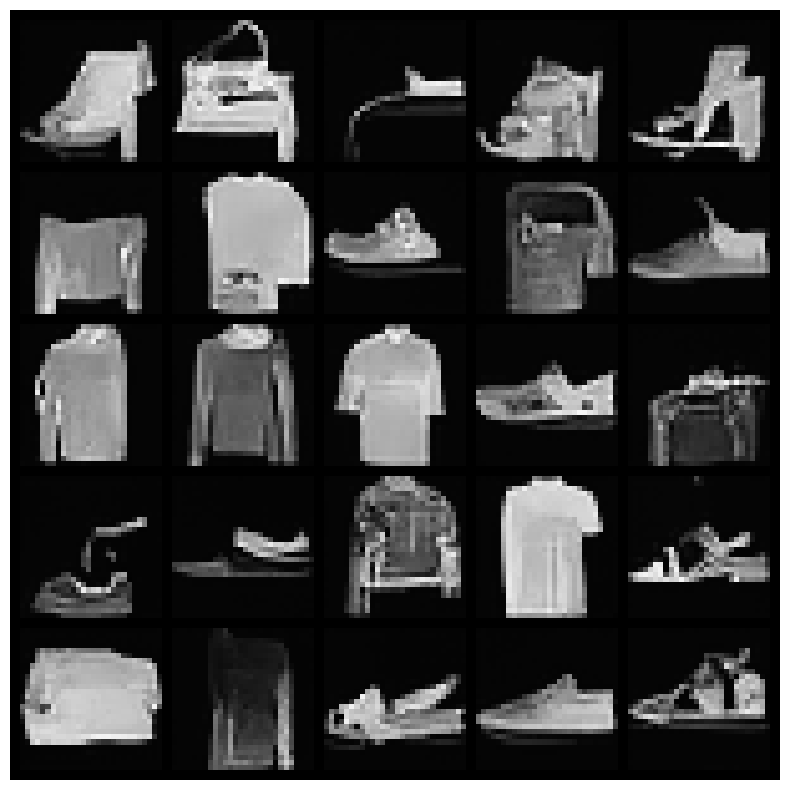

In [32]:
visualize_images(DM_samples[:25])

We did expect more from such a DM. However, the objects are still somewhat recognizable and do offer a clear structure. We will stick with as or teacher model.

### Adversarial pre-training of the generator
We implemented a generator that samples images of size 1x28x28 from a latent space of dimension 128. It incorporates a growing convolutional architectures of 3 layers. A discriminator with a mirror architecture was also implemented for the adversarial procedure.

Training is quite fast and can achieve results visibly better than the DM within 15 epochs. However here we want our generator to be worse than our DM, in order for it to have something to learn from the latter. To that end, we purposefully ran the adversarial training for 3 epochs only. This yields a very imperfect generator that still is good enough to produce what looks like objects that could be improved. This shortcut allows us to have somewhat of a shot at reproducing what is described in the DI paper for transferring a DM knowledge into a GAN.

Training can be reproduced as follows:

```
python3 train_GAN.py --latent_dim 128 --epochs 3
```

Let's now load and sample from this student model.

In [ ]:
from GAN import Generator
def generate_from_pretrained(generator, num_samples, latent_dim, device):
    z = torch.randn((num_samples, latent_dim), device=device)
    with torch.no_grad():
        fake_images = generator(z).cpu()
    return fake_images

def load_generator(model_path, latent_dim, img_channels, hidden_dim, device):
    generator = Generator(latent_dim, img_channels, hidden_dim).to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    return generator
    
generator_path = "GAN_models/best_generator.pth"
latent_dim = 128
img_channels = 1
hidden_dim = 128
num_samples = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = load_generator(generator_path, latent_dim, img_channels, hidden_dim, device)